Photo num 00 is:  0 	 expected:  0
Photo num 01 is:  1 	 expected:  1
Photo num 02 is:  2 	 expected:  2
Photo num 03 is:  1 	 expected:  1
Photo num 04 is:  none 	 expected:  0
Photo num 05 is:  8 	 expected:  8
Photo num 06 is:  8 	 expected:  8
Photo num 07 is:  2 	 expected:  8
Photo num 08 is:  8 	 expected:  8
Photo num 09 is:  4 	 expected:  4
Photo num 10 is:  5 	 expected:  5
Photo num 11 is:  7 	 expected:  7
Photo num 12 is:  5 	 expected:  5
Photo num 13 is:  4 	 expected:  4
Photo num 14 is:  7 	 expected:  7
Photo num 15 is:  none 	 expected:  6


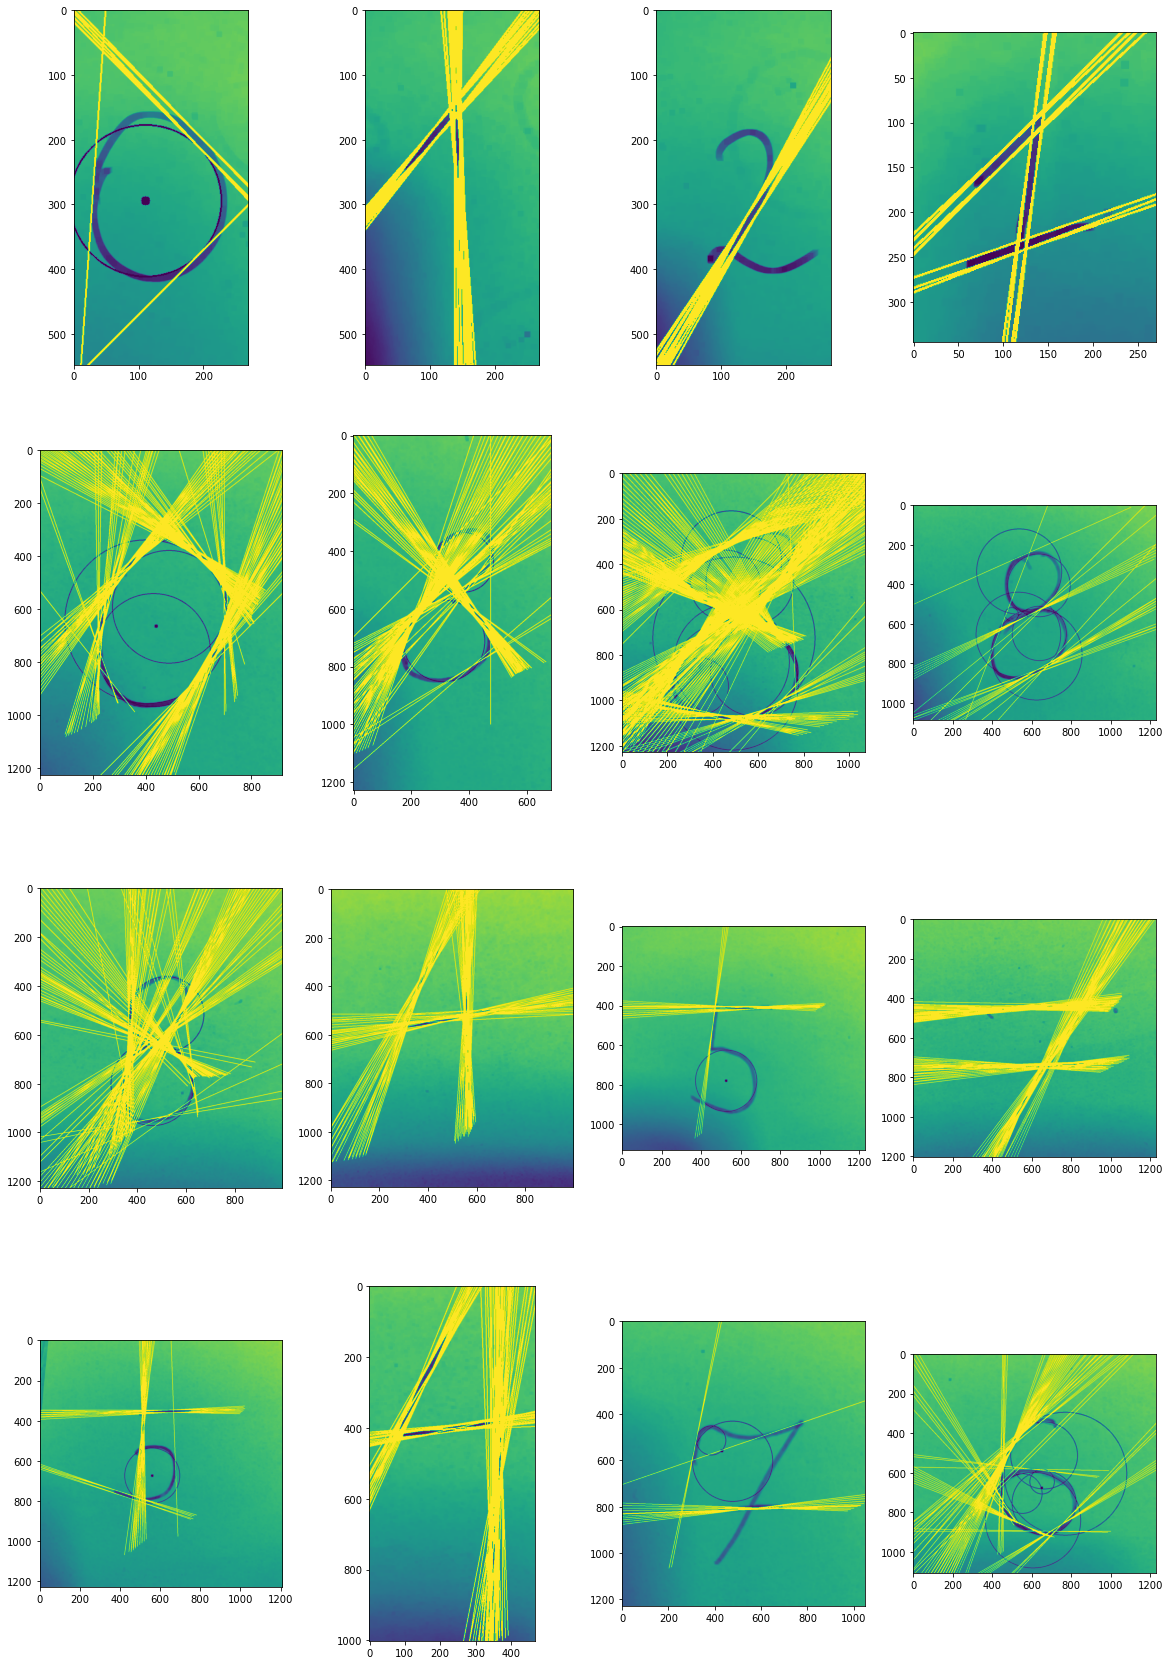

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import morphology, feature

n=16
plt_m=4
plt_n=int(n/plt_m)
fsize=(20,30)

scale_percent = 60
border_1 = 0.9
border_2 = 0.3
border_3 = 0.2
border_4 = 0.95
border_5=0.00008
proc_lines_domination = 0.8
min_sum_lines = 5
min_lines_on_center = 20

sq1=10
sq2=3

expected=[0,1,2,1,0,8,8,8,8,4,5,7,5,4,7,6]
pictures=[]
for i in range(n):
    tmp=str(i)
    if(i<10):
        tmp='0'+tmp
    pictures.append(tmp)

def avg(x):
    return int(sum(x)/len(x))

def main():
    
    global plt_m,plt_n,n
    plt.figure(figsize=fsize)
    sub=1
    
    for table in pictures:
        plt.subplot(plt_n,plt_m,sub)
        image=cv2.imread('data/calc_'+table+'.jpg')
        number='none'
        lines_on_center=0
        circ_avg_x=0
        circ_avg_y=0

        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        

        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #img=cv2.Canny(img,100,200)
        
        
        img = morphology.erosion(img, morphology.square(sq1))
        img = morphology.dilation(img, morphology.square(sq2))
        dst = cv2.Canny(img, 50, 200, None, 3)

        #----------------------------------------------------------
        circles = cv2.HoughCircles(
            img,
            cv2.HOUGH_GRADIENT,
            1,
            100,
            param1=50,
            param2=40,
            minRadius=0,
            maxRadius=0
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0,:]:
                # draw the outer circle
                cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
                # draw the center of the circle
                #cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
            circ_avg_x=avg(circles[0,:,0])
            circ_avg_y=avg(circles[0,:,1])
            cv2.circle(img,(circ_avg_x,circ_avg_y),2,(0,255,255),10)

        #----------------------------------------------------------
        lines_H=0
        lines_V=0
        lines_slash=0
        lines_bslash=0

        lines = cv2.HoughLines(dst,1,np.pi/180,50)
        if lines is not None:
            for rho,theta in lines[:,0]:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))

                if circ_avg_x!=0:
                    #if (circ_avg_y/height)-0.01<=a*(circ_avg_x/width)+b<=(circ_avg_y/height)+0.01:
                    if(np.sin(theta)!=0):
                        tmp=int(rho/np.sin(theta) + circ_avg_x*(-(np.cos(theta)/np.sin(theta))))
                        if  tmp-(width*height*border_5) <= circ_avg_y <= tmp+(width*height*border_5):
                            lines_on_center+=1
                
                cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)

                if abs(a)<border_3:
                    lines_H+=1
                elif abs(a)>border_4:
                    lines_V+=1
                elif border_1>a>border_2:
                    lines_slash+=1
                elif -border_1<a<-border_2:
                    lines_bslash+=1
        #----------------------------------------------------------
        suma=sum([lines_H,lines_V,lines_slash,lines_bslash])
        
        if suma > min_sum_lines:
            if ((lines_slash)/suma) >= proc_lines_domination:
                number=2
            elif ((lines_H+lines_slash)/suma) >= proc_lines_domination:
                    number=7
            elif circles is None:
                if ((lines_H+lines_slash)/suma) >= proc_lines_domination:
                    number=7
                elif ((lines_V+lines_slash)/suma) >= proc_lines_domination:
                    number=1
                else: number=4
                #print("Photo num ",sub-1,": ",lines_H,lines_V,lines_slash,lines_bslash)
            elif len(circles[0,:])==1:
                if ((lines_H+lines_V)/suma) >= proc_lines_domination:
                    number=5
                else:
                    number=0
            elif lines_on_center>=min_lines_on_center:
                number=8
        #----------------------------------------------------------
        tmp=str(sub-1)
        if(sub-1<10):
            tmp='0'+tmp
        print("Photo num",tmp,"is: ",number,"\t expected: ",expected[sub-1])

        plt.imshow(img)
        sub+=1
        #----------------------------------------------------------
    plt.show()

    
if __name__=='__main__':
    main()